In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt

In [20]:
GENERATE_RES = 7 # Generation resolution factor 
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3

# Preview image 
PREVIEW_ROWS = 1
PREVIEW_COLS = 1
PREVIEW_MARGIN = 0

# Size vector to generate images from
SEED_SIZE = 100

# Configuration
DATA_PATH = '/home/sanjana/Desktop/Final_Year_Proj/dataset_original/original/SCC'
EPOCHS = 1000
BATCH_SIZE = 32
BUFFER_SIZE = 60000

print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 224px square images.


In [21]:
training_binary_path = os.path.join(DATA_PATH,
        f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
  start = time.time()
  print("Loading training images...")

  training_data = []
  faces_path = os.path.join(DATA_PATH)
  for filename in tqdm(os.listdir(faces_path)):
      path = os.path.join(faces_path,filename)
      image = Image.open(path).resize((GENERATE_SQUARE,
            GENERATE_SQUARE),Image.ANTIALIAS)
      training_data.append(np.asarray(image))
  training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
            GENERATE_SQUARE,IMAGE_CHANNELS))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.


  print("Saving training image binary...")
  np.save(training_binary_path,training_data)
  elapsed = time.time()-start
  #print (f'Image preprocess time: {hms_string(elapsed)}')
else:
  print("Loading previous training pickle...")
  training_data = np.load(training_binary_path)

Looking for file: /home/sanjana/Desktop/Final_Year_Proj/dataset_original/original/SCC/training_data_224_224.npy
Loading previous training pickle...


In [22]:
train_dataset = tf.data.Dataset.from_tensor_slices(training_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [23]:
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
   
    # Output resolution, additional upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    if GENERATE_RES>1:
      model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
      model.add(Conv2D(256,kernel_size=3,padding="same"))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model


def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(256, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [24]:
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join(DATA_PATH,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

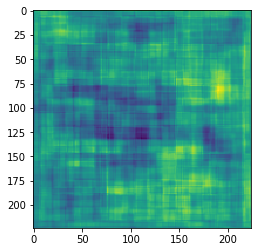

In [25]:
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [26]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.49970263]], shape=(1, 1), dtype=float32)


In [27]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [28]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

In [29]:
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  return gen_loss,disc_loss

In [30]:
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, 
                                       SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'
           ' {hms_string(epoch_elapsed)}')
    save_images(g_loss,fixed_seed)

  elapsed = time.time()-start
  #print (f'Training time: {hms_string(elapsed)}')

In [ ]:
train(train_dataset, EPOCHS)

Epoch 1, gen loss=5.576066970825195,disc loss=4.112331867218018, {hms_string(epoch_elapsed)}
1/1 [==============================] - 1s 695ms/step
Epoch 2, gen loss=2.7234809398651123,disc loss=3.698554277420044, {hms_string(epoch_elapsed)}
1/1 [==============================] - 1s 525ms/step
Epoch 3, gen loss=7.113288402557373,disc loss=0.40350833535194397, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 497ms/step
Epoch 4, gen loss=5.289163589477539,disc loss=1.8110812902450562, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 482ms/step
Epoch 5, gen loss=13.805109977722168,disc loss=2.2173001766204834, {hms_string(epoch_elapsed)}
1/1 [==============================] - 1s 569ms/step
Epoch 6, gen loss=7.477564334869385,disc loss=0.26301977038383484, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 495ms/step
Epoch 7, gen loss=4.486212253570557,disc loss=0.735088586807251, {hms_string(epoch_elapsed)}
1/1 [==================

1/1 [==============================] - 1s 603ms/step
Epoch 57, gen loss=16.145601272583008,disc loss=0.3844318687915802, {hms_string(epoch_elapsed)}
1/1 [==============================] - 1s 654ms/step
Epoch 58, gen loss=29.196962356567383,disc loss=9.77466106414795, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 461ms/step
Epoch 59, gen loss=15.734513282775879,disc loss=0.7976800799369812, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 453ms/step
Epoch 60, gen loss=28.905324935913086,disc loss=0.01983697898685932, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 457ms/step
Epoch 61, gen loss=19.7263240814209,disc loss=0.02382371574640274, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 500ms/step
Epoch 62, gen loss=20.23395347595215,disc loss=2.1413042545318604, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 484ms/step
Epoch 63, gen loss=26.734100341796875,disc loss=1.911393

1/1 [==============================] - 0s 486ms/step
Epoch 112, gen loss=19.659364700317383,disc loss=0.09264883399009705, {hms_string(epoch_elapsed)}
1/1 [==============================] - 1s 607ms/step
Epoch 113, gen loss=11.309067726135254,disc loss=0.04792890325188637, {hms_string(epoch_elapsed)}
1/1 [==============================] - 1s 564ms/step
Epoch 114, gen loss=12.386567115783691,disc loss=3.5859086513519287, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 477ms/step


In [43]:
'''
import cv2
import numpy as np
# load path of the image
dirr = "/home/sanjana/Desktop/Final_Year_Proj/dataset_original/FYP/outputs-sharp/output-hsil/"
for img in os.listdir(fdirr):
    original_image=cv2.imread(img)
# create a sharpening kernel
    sharpen_filter=np.array([
      [0, -1, 0],
      [-1, 5, -1],
      [0, -1, 0]
    ])
# applying kernels to the input image to get the sharpened image
    sharp_image=cv2.filter2D(original_image,-1,sharpen_filter)
    cv2.imwrite('/home/sanjana/Desktop/Final_Year_Proj/dataset_original/FYP/outputs-sharp/output-hsil/img-%s.jpg', sharp_image)

NameError: name 'model' is not defined

In [30]:
'''
from PIL import Image
import os, sys
import numpy as np
import cv2

path = "/home/sanjana/Desktop/Final_Year_Proj/dataset_original/FYP/outputs-sharp/scc/"
dirs = os.listdir(path)

def resize():
    for item in dirs:
        if os.path.isfile(path+item):
            im = cv2.imread(path+item)
            f, e = os.path.splitext(path+item)
            sharpen_filter=np.array([[0, -1, 0],[-1, 5, -1],[0, -1, 0]])
            sharp_image=cv2.filter2D(im,-1,sharpen_filter)
            
            cv2.imwrite(f + ' sharp.jpg', sharp_image)

resize()
'''